Load Julia packages (libraries) needed  for the snippets in chapter 0

In [1]:
using StatisticalRethinking
using CmdStan, StanMCMCChain, MCMCChain, Distributions, Statistics, StatPlots, Plots
gr(size=(500,800))

Plots.GRBackend()

CmdStan uses a tmp directory to store the output of cmdstan

In [2]:
ProjDir = @__DIR__
cd(ProjDir) #do

### snippet 4.7

In [3]:
howell1 = CSV.read(joinpath(dirname(Base.pathof(StatisticalRethinking)), "..", "data", "Howell1.csv"), delim=';')
df = convert(DataFrame, howell1)

,height,weight,age,male
,Float64⍰,Float64⍰,Float64⍰,Int64⍰
1,151.765,47.8256,63.0,1
2,139.7,36.4858,63.0,0
3,136.525,31.8648,65.0,0
4,156.845,53.0419,41.0,1
5,145.415,41.2769,51.0,0
6,163.83,62.9926,35.0,1
7,149.225,38.2435,32.0,0
8,168.91,55.48,27.0,1
9,147.955,34.8699,19.0,0


Use only adults

In [4]:
df2 = filter(row -> row[:age] >= 18, df)

,height,weight,age,male
,Float64⍰,Float64⍰,Float64⍰,Int64⍰
1,151.765,47.8256,63.0,1
2,139.7,36.4858,63.0,0
3,136.525,31.8648,65.0,0
4,156.845,53.0419,41.0,1
5,145.415,41.2769,51.0,0
6,163.83,62.9926,35.0,1
7,149.225,38.2435,32.0,0
8,168.91,55.48,27.0,1
9,147.955,34.8699,19.0,0


Define the Stan language model

In [5]:
heightsmodel = "
// Inferring a Rate
data {
  int N;
  real<lower=0> h[N];
}
parameters {
  real<lower=0> sigma;
  real<lower=0,upper=250> mu;
}
model {
  // Priors for mu and sigma
  mu ~ uniform(100, 250);
  sigma ~ cauchy( 0 , 1 );

  // Observed heights
  h ~ normal(mu, sigma);
}
"

"\n// Inferring a Rate\ndata {\n  int N;\n  real<lower=0> h[N];\n}\nparameters {\n  real<lower=0> sigma;\n  real<lower=0,upper=250> mu;\n}\nmodel {\n  // Priors for mu and sigma\n  mu ~ uniform(100, 250);\n  sigma ~ cauchy( 0 , 1 );\n\n  // Observed heights\n  h ~ normal(mu, sigma);\n}\n"

Make variables visible outisde the do loop

In [6]:
global stanmodel, chn

Define the Stanmodel and set the output format to :mcmcchain.

In [7]:
stanmodel = Stanmodel(name="heights", monitors = ["mu", "sigma"],model=heightsmodel,
  output_format=:mcmcchain)
# Input data for cmdstan
heightsdata = [
  Dict("N" => length(df2[:height]), "h" => df2[:height])
]

=====> /Users/rob/.julia/dev/StatisticalRethinking/notebooks/04



1-element Array{Dict{String,Any},1}:
 Dict("N"=>352,"h"=>Union{Missing, Float64}[151.765, 139.7, 136.525, 156.845, 145.415, 163.83, 149.225, 168.91, 147.955, 165.1  …  156.21, 160.655, 146.05, 156.21, 152.4, 162.56, 142.875, 162.56, 156.21, 158.75])

Sample using cmdstan

In [8]:
rc, chn, cnames = stan(stanmodel, heightsdata, ProjDir, diagnostics=false,
  CmdStanDir=CMDSTAN_HOME)
# Describe the draws
display(describe(chn))


make: `/Users/rob/.julia/dev/StatisticalRethinking/notebooks/04/tmp/heights' is up to date.

Length of data array is not equal to nchains,
all chains will use the first data dictionary.

Calling /Users/rob/Projects/StanSupport/cmdstan/bin/stansummary to infer across chains.

Inference for Stan model: heights_model
4 chains: each with iter=(1000,1000,1000,1000); warmup=(0,0,0,0); thin=(1,1,1,1); 4000 iterations saved.

Warmup took (0.032, 0.033, 0.033, 0.032) seconds, 0.13 seconds total
Sampling took (0.047, 0.054, 0.049, 0.049) seconds, 0.20 seconds total

                Mean     MCSE  StdDev    5%   50%   95%    N_Eff  N_Eff/s    R_hat
lp__            -895  2.2e-02    0.98  -897  -895  -894  2.0e+03  9.9e+03  1.0e+00
accept_stat__   0.92  1.5e-03    0.10  0.70  0.96   1.0  4.8e+03  2.4e+04  1.0e+00
stepsize__      0.83  2.6e-02   0.037  0.77  0.86  0.87  2.0e+00  1.0e+01  2.6e+13
treedepth__      1.9  5.9e-02    0.57   1.0   2.0   3.0  9.3e+01  4.7e+02  1.0e+00
n_leapfrog__     4.2 

Plot the density of posterior draws

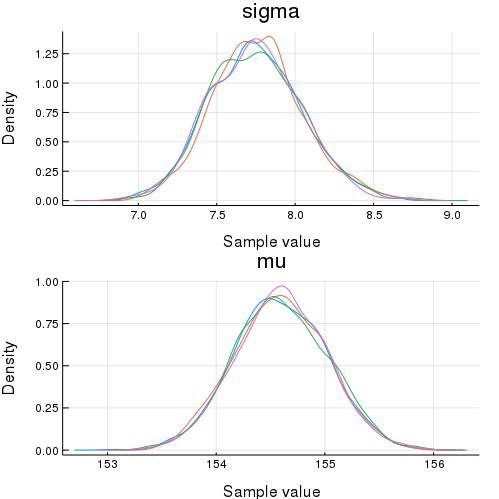

In [9]:
density(chn)#-

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*